In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hrnet/tensorflow2/hrnet-ade20k-hrnetv2-w48/1/saved_model.pb
/kaggle/input/hrnet/tensorflow2/hrnet-ade20k-hrnetv2-w48/1/variables/variables.index
/kaggle/input/hrnet/tensorflow2/hrnet-ade20k-hrnetv2-w48/1/variables/variables.data-00000-of-00001
/kaggle/input/football-player-segmentation/annotations/instances_default.json
/kaggle/input/football-player-segmentation/images/208.jpg
/kaggle/input/football-player-segmentation/images/473.jpg
/kaggle/input/football-player-segmentation/images/333.jpg
/kaggle/input/football-player-segmentation/images/45.jpg
/kaggle/input/football-player-segmentation/images/369.jpg
/kaggle/input/football-player-segmentation/images/56.jpg
/kaggle/input/football-player-segmentation/images/89.jpg
/kaggle/input/football-player-segmentation/images/20.jpg
/kaggle/input/football-player-segmentation/images/275.jpg
/kaggle/input/football-player-segmentation/images/212.jpg
/kaggle/input/football-player-segmentation/images/239.jpg
/kaggle/input/football-player-

In [25]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8jughly6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-8jughly6
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=e52278f72a7b8b7bd658e83cc576209e67a4451c9b85e84fa9d50456950dd75b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbgiz2ry/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 16.1 MB/s eta 0:00:0000:0100:01


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

Il set di dati che verrà utilizzato per questo tutorial è l'Oxford-IIIT Pet Dataset, creato da Parkhi et al. Il set di dati è costituito da immagini, etichette corrispondenti e maschere pixel-wise. Le maschere sono fondamentalmente etichette per ciascun pixel. Ad ogni pixel viene assegnata una delle tre categorie: Classe 1: Pixel appartenente all'animale domestico. Classe 2: Pixel confinante con l'animale domestico. Classe 3: Nessuna delle precedenti/Pixel circostante.

In [14]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Il codice seguente esegue un semplice aumento del capovolgimento di un'immagine. Inoltre, l'immagine viene normalizzata su [0,1]. Infine, come accennato in precedenza, i pixel nella maschera di segmentazione sono etichettati {1, 2, 3}. Per comodità, sottraiamo 1 dalla maschera di segmentazione, ottenendo le etichette: {0, 1, 2}.

In [15]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Viene applicata una trasformazione ai dati casuale: con una probabilità del 50%, il codice inverte orizzontalmente input_image e la sua corrispondente input_mask utilizzando tf.image.flip_left_right.

In [16]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [17]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Il set di dati contiene già le suddivisioni richieste di test e training, quindi riporto i parametri utilizzati.

In [18]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [20]:
#Il codice crea un flusso di dati di addestramento
#(train_dataset) che è stato mescolato, raggruppato in batch,
#e memorizzato nella cache, e un flusso di dati di test 
#(test_dataset) raggruppato in batch. La prefetching è abilitata
#per ottimizzare l'accesso ai dati durante l'addestramento.

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Definiamo adesso un modello base da andare ad allenare su questi dati appena processati.

Il modello utilizzato qui è una U-Net modificata. 
Una U-Net è composta da un codificatore (downsampler) 
e un decodificatore (upsampler). Per apprendere funzionalità
robuste e ridurre il numero di parametri addestrabili,
è possibile utilizzare un modello preaddestrato come
codificatore. Pertanto, il codificatore per questa attività 
sarà un modello MobileNetV2 preaddestrato, di cui verranno 
utilizzati gli output intermedi, e il decodificatore sarà il
blocco upsample già implementato negli esempi TensorFlow nel
tutorial Pix2pix. Il motivo per cui vengono generati tre canali
è perché ci sono tre possibili etichette per ciascun pixel.

In [21]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]



In [32]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output


down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

La funzione di costo/perdita utilizzata è losses.SparseCategoricalCrossentropy(from_logits=True).
Il motivo per utilizzare questa funzione di perdita è perché la rete sta cercando di assegnare a ciascun pixel un'etichetta. Nella vera maschera di segmentazione, ogni pixel ha un {0,1,2}. La rete qui emette tre canali. Essenzialmente, ogni canale sta cercando di imparare a prevedere una classe e le perdite. SparseCategoricalCrossentropy(from_logits=True) è la perdita consigliata per tale scenario. Utilizzando l'output della rete, l'etichetta assegnata al pixel è il canale con il valore più alto. Questo è ciò che farà la funzione create_mask.

In [29]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Sapere come si comportano le perdite di addestramento (training loss) e di validazione (validation loss) è fondamentale durante il processo di allenamento di un modello di machine learning.

* La perdita è una misura della discrepanza tra le previsioni del modello e i valori reali. Monitorare la perdita durante l'addestramento fornisce un'indicazione di quanto bene il modello sta imparando dai dati di addestramento.

* Se la loss di addestramento diminuisce ma quella di validazione aumenta, potrebbe essere segno di overfitting

* La loss di validazione può essere utilizzata come criterio per l'arresto anticipato. Se la loss di validazione smette di migliorare o inizia ad aumentare, potrebbe essere un segnale di overfitting

In [33]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])


Sample Prediction after epoch 10

57/57 [==============================] - 193s 3s/step - loss: 0.2004 - accuracy: 0.9124 - val_loss: 0.2764 - val_accuracy: 0.8912


Vediamo quindi l'andamento della validation_loss e training_loss

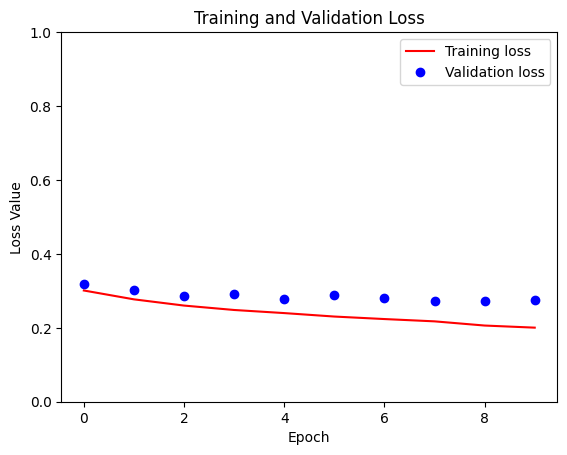

In [35]:
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [41]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [44]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [45]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 2s 772ms/step


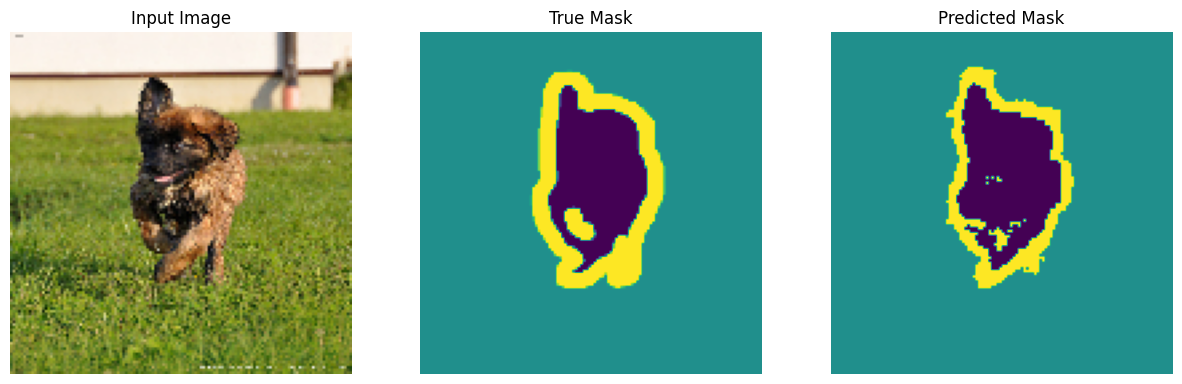

2/2 [==============================] - 2s 769ms/step


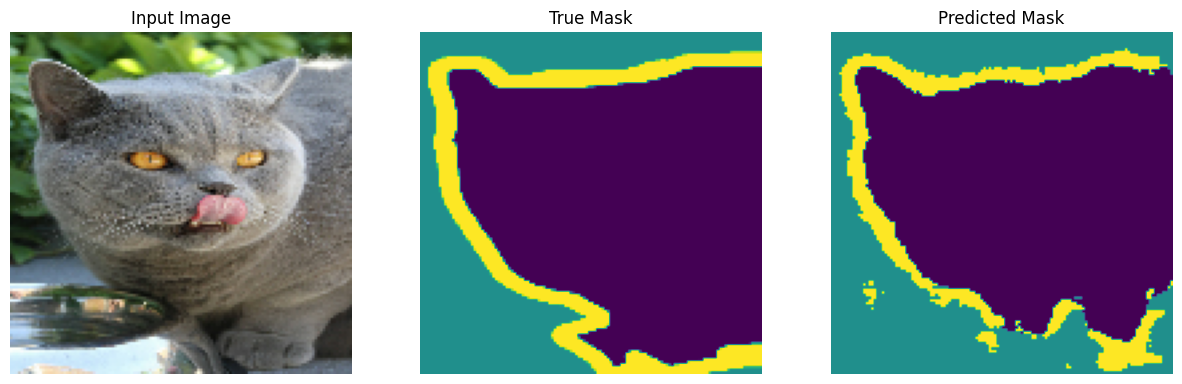

2/2 [==============================] - 2s 750ms/step


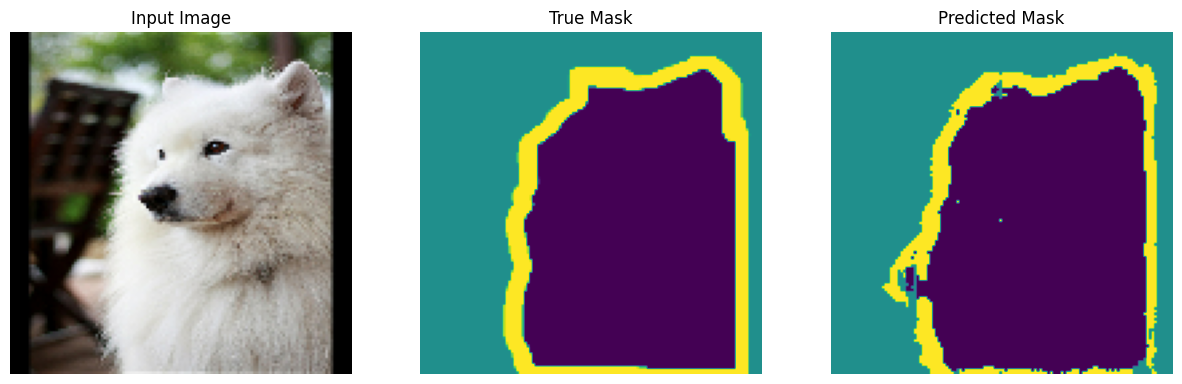

2/2 [==============================] - 2s 762ms/step


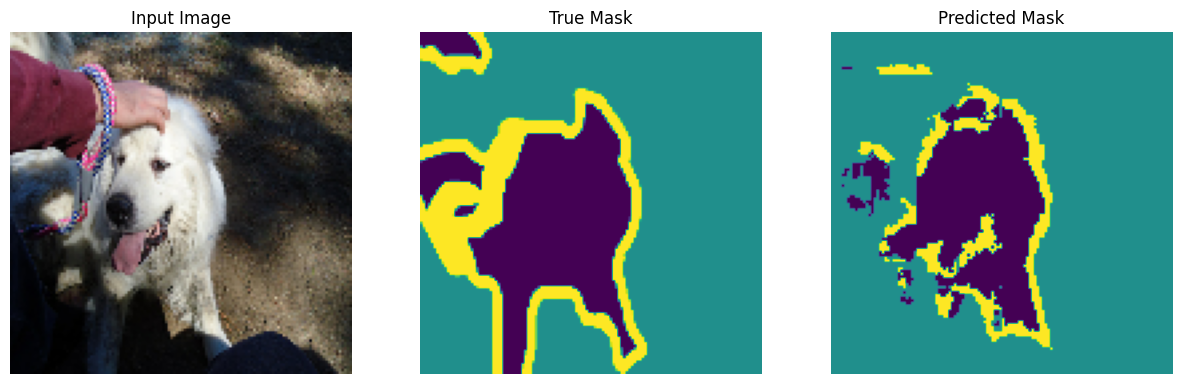

2/2 [==============================] - 2s 804ms/step


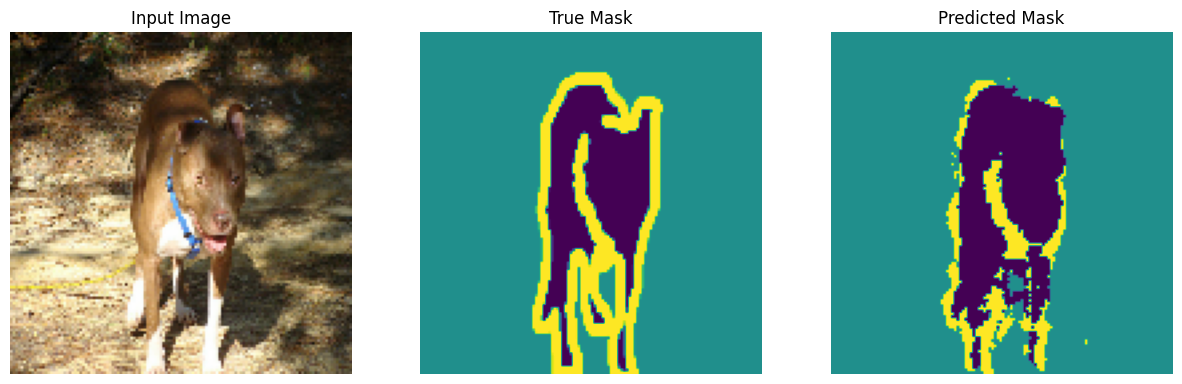

In [49]:
show_predictions(test_dataset,5)
